In [128]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pandas as pd

# bibliotecas pra treinar o modelo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import seaborn as sns

# metricas de avaliacao
from sklearn.metrics import roc_curve, auc

# Ingestão dos dados

In [129]:
customers_path = 'data/olist_customers_dataset.csv'
geolocation_path = 'data/olist_geolocation_dataset.csv'
order_items_path = 'data/olist_order_items_dataset.csv'
order_payments_path = 'data/olist_order_payments_dataset.csv'
order_reviews_path = 'data/olist_order_reviews_dataset.csv'
orders_path = 'data/olist_orders_dataset.csv'
products_path = 'data/olist_products_dataset.csv'
sellers_path = 'data/olist_sellers_dataset.csv'
category_path = 'data/product_category_name_translation.csv'

In [130]:
customers_df = pd.read_csv(customers_path)
geolocation_df = pd.read_csv(geolocation_path)
order_items_df = pd.read_csv(order_items_path)
order_payments_df = pd.read_csv(order_payments_path)
order_reviews_df = pd.read_csv(order_reviews_path)
orders_df = pd.read_csv(orders_path)
products_df = pd.read_csv(products_path)
sellers_df = pd.read_csv(sellers_path)
category_df = pd.read_csv(category_path)

tabelas = {
    'customers': customers_df,
    'geolocation': geolocation_df,
    'order_items': order_items_df,
    'order_payments': order_payments_df,
    'order_reviews': order_reviews_df,
    'orders': orders_df,
    'products': products_df,
    'sellers': sellers_df,
    'category': category_df
}

# Visão Geral das bases


In [131]:
for nome,df in tabelas.items():
  print(f"TABELA: {nome}")
  print(df.info())

TABELA: customers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
TABELA: geolocation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geol

# Preparação dos Dados

In [132]:
for nome,df in tabelas.items():
  print(f"TABELA: {nome}")
  print(df.isnull().sum()) # ver quantidade de valores nulos
  print(df.duplicated().sum()) # ver quantidade de linhas duplicadas

TABELA: customers
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
0
TABELA: geolocation
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
261831
TABELA: order_items
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
0
TABELA: order_payments
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
0
TABELA: order_reviews
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_

In [133]:
# substitui valores nulos de avaliações por strings vazias '' para evitar perder o restante das colunas daquela linha principalmente o score. ajuda também a evitar problemas com tipos de dados inválidos

order_reviews_df['review_comment_title'] = order_reviews_df['review_comment_title'].fillna('')
order_reviews_df['review_comment_message'] = order_reviews_df['review_comment_message'].fillna('')

In [134]:
# Justificativa:
# Decidi dropar as linhas com valores nulos porque:
# - O total de linhas com nulos nas colunas essenciais é pequeno (apenas 2 linhas para medidas físicas).
# - Essas colunas (peso, dimensões) são importantes e difíceis de imputar corretamente sem introduzir vieses.
# - Já existem outras colunas com nulos (610) na categoria que podem ser eliminadas para simplificar, 
#   já que a perda relativa de dados é pequena (cerca de 2% do total).
# - Dropar evita dados inconsistentes ou imprecisos, garantindo qualidade para análises e modelos futuros.

# Dropar linhas com valores nulos em qualquer coluna do DataFrame
products_df = products_df.dropna()


# como os valores nulos não eram muitos comparado ao total de linhas e também são valores do tipo DATA utilizados para calculo de tempo, optei por apagar as linhas com valores nulos
orders_df = orders_df.dropna()

## Padronização de nomes de colunas


In [135]:
# corrige erro de escrita na coluna

products_df = products_df.rename(columns={
    'product_name_lenght': 'product_name_length',
    'product_description_lenght': 'product_description_length'
})

## Conversão de tipos


In [136]:
# Zip codes para string
customers_df['customer_zip_code_prefix'] = customers_df['customer_zip_code_prefix'].astype(str)
geolocation_df['geolocation_zip_code_prefix'] = geolocation_df['geolocation_zip_code_prefix'].astype(str)
sellers_df['seller_zip_code_prefix'] = sellers_df['seller_zip_code_prefix'].astype(str)

# quantidade de fotos de float para int já que não faz sentido ter uma quantidade de fotos com casas decimais
products_df['product_photos_qty'] = products_df['product_photos_qty'].astype(int)

# Datas para datetime
order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])
order_reviews_df['review_creation_date'] = pd.to_datetime(order_reviews_df['review_creation_date'])
order_reviews_df['review_answer_timestamp'] = pd.to_datetime(order_reviews_df['review_answer_timestamp'])

orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_delivered_carrier_date'] = pd.to_datetime(orders_df['order_delivered_carrier_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])



/tmp/ipykernel_28787/2645906848.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_28787/2645906848.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_28787/2645906848.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

## Modelagem Relacional


![Modelagem Relacional](ModelagemRelacional.png)


# Análise exploratória

In [137]:
tabelas = {
    'customers': customers_df,
    'geolocation': geolocation_df,
    'order_items': order_items_df,
    'order_payments': order_payments_df,
    'order_reviews': order_reviews_df,
    'orders': orders_df,
    'products': products_df,
    'sellers': sellers_df,
    'category': category_df
}


for nome,df in tabelas.items():
  print(f"TABELA: {nome}")
  print(df.info())

TABELA: customers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  object
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB
None
TABELA: geolocation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  object 
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_ci

### Conexão SQLITE

In [138]:
conn = sqlite3.connect(':memory:')  # banco temporário na RAM

customers_df.to_sql('customers', conn, index=False, if_exists='replace')
orders_df.to_sql('orders', conn, index=False, if_exists='replace')
order_items_df.to_sql('order_items', conn, index=False, if_exists='replace')
products_df.to_sql('products', conn, index=False, if_exists='replace')
sellers_df.to_sql('sellers', conn, index=False, if_exists='replace')
geolocation_df.to_sql('geolocation', conn, index=False, if_exists='replace')
order_payments_df.to_sql('order_payments', conn, index=False, if_exists='replace')
order_reviews_df.to_sql('order_reviews', conn, index=False, if_exists='replace')
category_df.to_sql('category', conn, index=False, if_exists='replace')


71

### Qual o volume de pedidos por mês ? Existe sazonalidade nas vendas?


- R: Volume de pedidos do mês decidi exibir um gráfico para melhor visualização
- R: Pela visualização do gráfico que se trata de um gráfico de tendência crescente e não possui sazonalidade

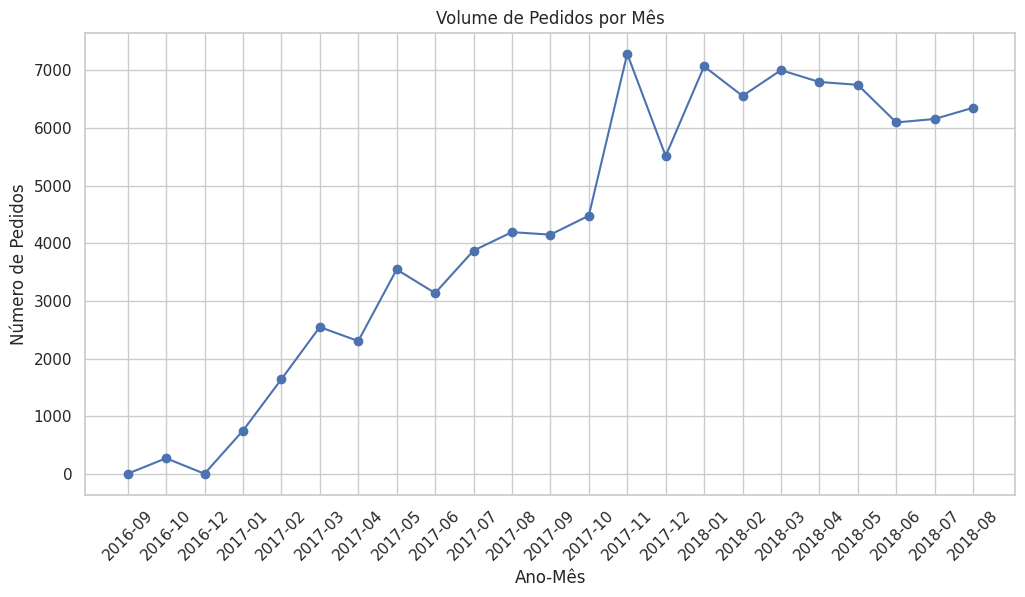

In [139]:
# a) Volume de pedidos por mês
query = """
SELECT 
    strftime('%Y-%m', order_purchase_timestamp) AS ano_mes,
    COUNT(order_id) AS total_pedidos
FROM orders
GROUP BY ano_mes
ORDER BY ano_mes;
"""
df = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
plt.plot(df['ano_mes'], df['total_pedidos'], marker='o')
plt.xticks(rotation=45)
plt.title('Volume de Pedidos por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Número de Pedidos')
plt.grid(True)
plt.show()

### Qual a distribuição do tempo de entrega dos pedidos?

- R: Plotagem de gráfico para visualização da distribuição
 

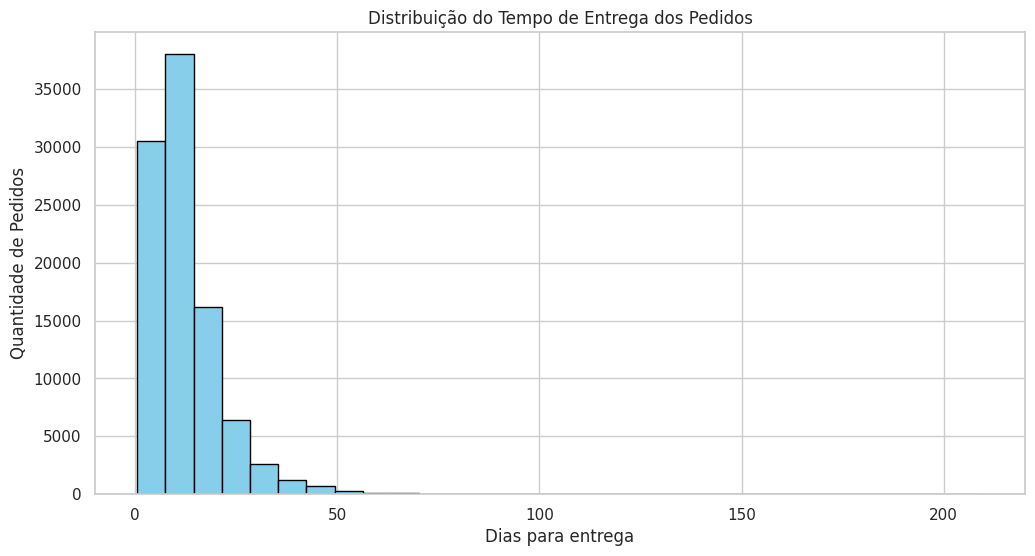

In [140]:
query = """
SELECT 
    JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp) AS dias_entrega
FROM orders
WHERE order_delivered_customer_date IS NOT NULL
  AND order_purchase_timestamp IS NOT NULL;
"""
df = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
plt.hist(df['dias_entrega'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição do Tempo de Entrega dos Pedidos')
plt.xlabel('Dias para entrega')
plt.ylabel('Quantidade de Pedidos')
plt.grid(True)
plt.show()


### Qual a relação entre o valor do frete e a distância de entrega?

- R: Plotagem de gráfico para melhor visualizar a relação , calculei a distancia entre o vendedor e o cliente através da latitude e longitude , transformando isso em km pela formula de Haversine


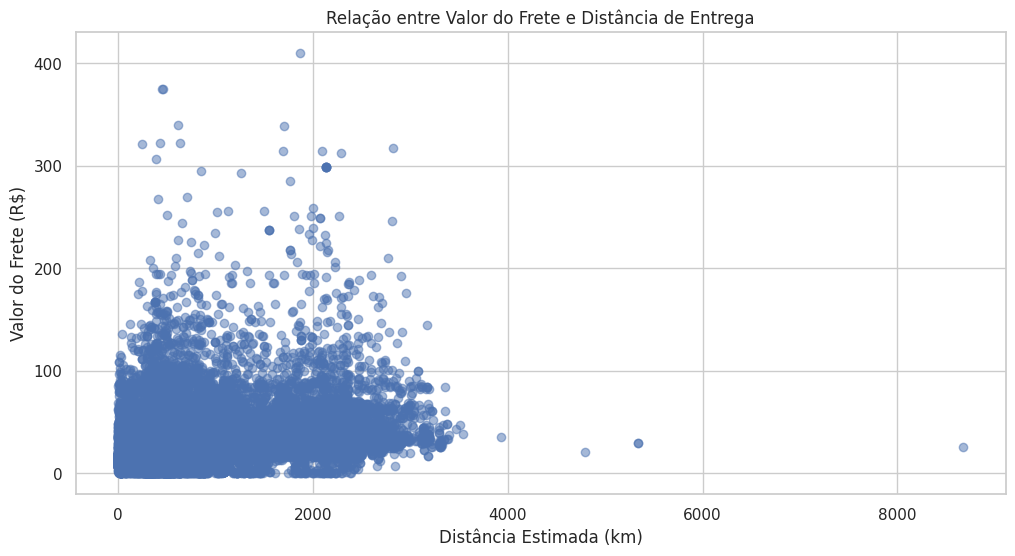

In [141]:
query = """
WITH geo_avg AS (
    SELECT 
        geolocation_zip_code_prefix AS zip_code_prefix,
        AVG(geolocation_lat) AS lat,
        AVG(geolocation_lng) AS lng
    FROM geolocation
    GROUP BY geolocation_zip_code_prefix
),
customer_coords AS (
    SELECT 
        customer_id,
        ga.lat AS cust_lat,
        ga.lng AS cust_lng
    FROM customers c
    JOIN geo_avg ga ON c.customer_zip_code_prefix = ga.zip_code_prefix
),
seller_coords AS (
    SELECT 
        seller_id,
        ga.lat AS sell_lat,
        ga.lng AS sell_lng
    FROM sellers s
    JOIN geo_avg ga ON s.seller_zip_code_prefix = ga.zip_code_prefix
),
freight_distance AS (
    SELECT 
        oi.freight_value,
        6371 * 2 * 
        ASIN(
            SQRT(
                POWER(SIN(RADIANS((sc.sell_lat - cc.cust_lat) / 2)), 2) +
                COS(RADIANS(cc.cust_lat)) * COS(RADIANS(sc.sell_lat)) *
                POWER(SIN(RADIANS((sc.sell_lng - cc.cust_lng) / 2)), 2)
            )
        ) AS distancia_km
    FROM order_items oi
    JOIN orders o ON oi.order_id = o.order_id
    JOIN customer_coords cc ON o.customer_id = cc.customer_id
    JOIN seller_coords sc ON oi.seller_id = sc.seller_id
)
SELECT freight_value, distancia_km
FROM freight_distance
WHERE distancia_km IS NOT NULL;
"""


df = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
plt.scatter(df['distancia_km'], df['freight_value'], alpha=0.5)
plt.title('Relação entre Valor do Frete e Distância de Entrega')
plt.xlabel('Distância Estimada (km)')
plt.ylabel('Valor do Frete (R$)')
plt.grid(True)
plt.show()

### Quais são as categorias de produtos mais vendidas em termos de faturamento?

- R: plotei gráfico de barras para visualização sendo a categoria beleza/saude a mais vendida


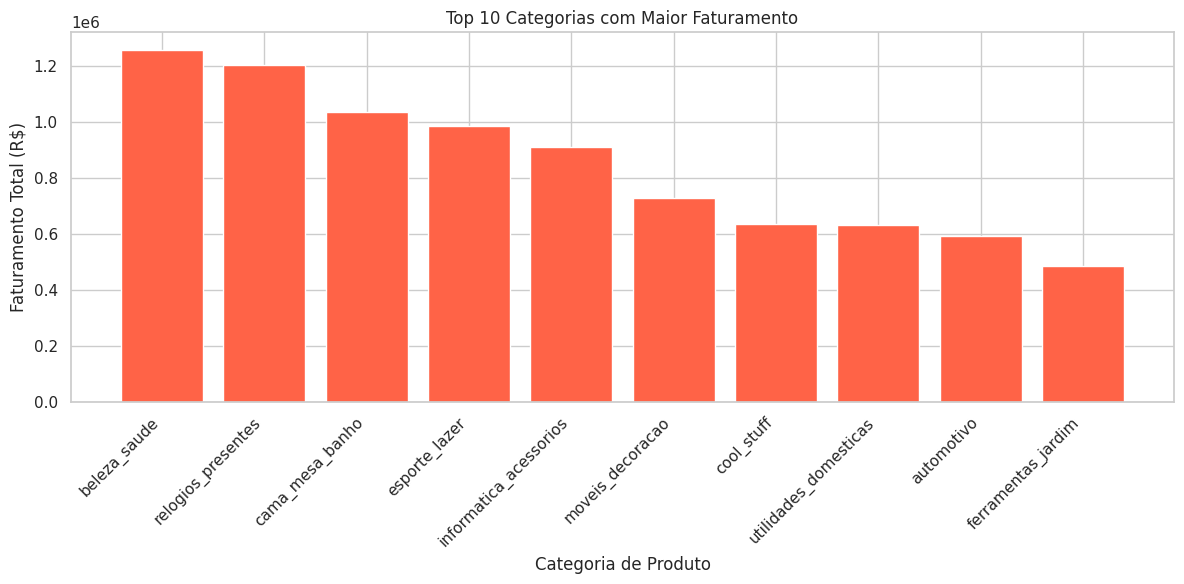

In [142]:
query = """
SELECT 
    p.product_category_name,
    SUM(oi.price) AS total_faturamento
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY total_faturamento DESC
LIMIT 10;
"""
df = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
plt.bar(df['product_category_name'], df['total_faturamento'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Categorias com Maior Faturamento')
plt.xlabel('Categoria de Produto')
plt.ylabel('Faturamento Total (R$)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Quais estados brasileiros possuem o maior valor médio de pedido?

- R: plotei gráfico de barras para melhor visualização , sendo o estado da Paraiba o com mais preço médio por produto

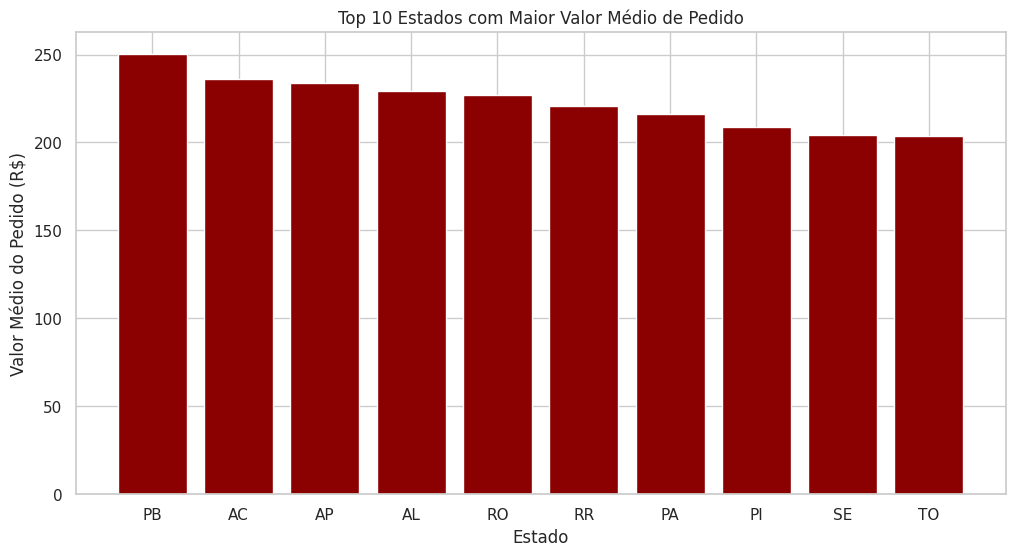

In [143]:
query = """
SELECT 
    c.customer_state,
    AVG(op.payment_value) AS valor_medio_pedido
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_payments op ON o.order_id = op.order_id
GROUP BY c.customer_state
ORDER BY valor_medio_pedido DESC
LIMIT 10;
"""
df = pd.read_sql_query(query, conn)

plt.figure(figsize=(12,6))
plt.bar(df['customer_state'], df['valor_medio_pedido'], color='darkred')
plt.title('Top 10 Estados com Maior Valor Médio de Pedido')
plt.xlabel('Estado')
plt.ylabel('Valor Médio do Pedido (R$)')
plt.grid(True)
plt.show()


# Solução de Problemas de Negócio


## Análise de retenção

#### ps : não possuem clientes com compras recorrentes

In [144]:
query = """
SELECT customer_id, COUNT(order_id) AS total_pedidos
FROM orders
GROUP BY customer_id
HAVING COUNT(order_id) > 1
"""

df = pd.read_sql_query(query, conn)
conn.close()
print(df)


Empty DataFrame
Columns: [customer_id, total_pedidos]
Index: []


In [145]:
orders_df['customer_id'].value_counts().max()
# não possuem clientes com mais de 1 compra

np.int64(1)

## Predição de Atraso

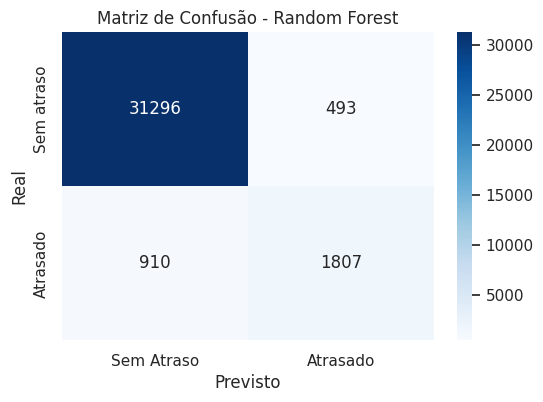

In [146]:
# 1. Definindo o target: atraso = data de entrega real > data estimada
orders_df['is_late'] = (orders_df['order_delivered_customer_date'] > orders_df['order_estimated_delivery_date']).astype(int)

# 2. Criando features relevantes (tempo de entrega, tempo de aprovação, valor do frete e valor do pagamento)
orders_df['delivery_time'] = (orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']).dt.days
orders_df['approval_time'] = (orders_df['order_approved_at'] - orders_df['order_purchase_timestamp']).dt.seconds / 3600

# Merge com pagamentos e itens para obter valor e frete
order_stats = pd.merge(orders_df, order_items_df[['order_id', 'freight_value']], on='order_id', how='left')
order_stats = pd.merge(order_stats, order_payments_df[['order_id', 'payment_value']], on='order_id', how='left')

# Remover nulos
order_stats = order_stats.dropna(subset=['delivery_time', 'approval_time', 'freight_value', 'payment_value'])

# 3. Seleção de features 
X = order_stats[['delivery_time', 'approval_time', 'freight_value', 'payment_value']]
y = order_stats['is_late']

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# dividindo base em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 4. Modelo: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Avaliação
report_rf = classification_report(y_test, y_pred, output_dict=True)
confusion_rf = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6,4))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Atraso', 'Atrasado'], yticklabels=['Sem atraso', 'Atrasado'])
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

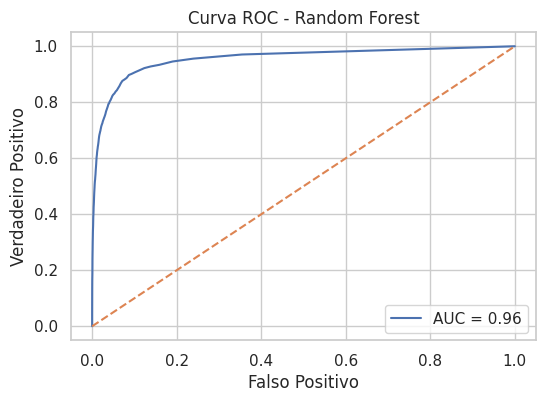

In [147]:
# aqui serve para avaliar melhor a qualidade do modelo random forest além de fornecer uma forma mais visual através da Métrica ROC/AUC

y_proba = rf_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.grid(True)
plt.show()


## Segmentação de Cliente

- Permite identificar quais estados geram mais receita ou têm maior número de pedidos.
- Ajuda a direcionar estratégias de marketing, logística e expansão regional.
- Facilita a detecção de estados com baixo desempenho, onde melhorias podem ser aplicadas.

In [148]:
state_summary = (
    orders_df
    .merge(order_items_df, on='order_id')
    .merge(customers_df[['customer_id', 'customer_state']], on='customer_id')
    .groupby('customer_state')
    .agg(
        total_vendas=('price', 'sum'),
        total_pedidos=('order_id', 'count'),
        clientes_ativos=('customer_id', 'nunique')
    )
    .reset_index()
)
state_summary['ticket_medio'] = state_summary['total_vendas'] / state_summary['total_pedidos']

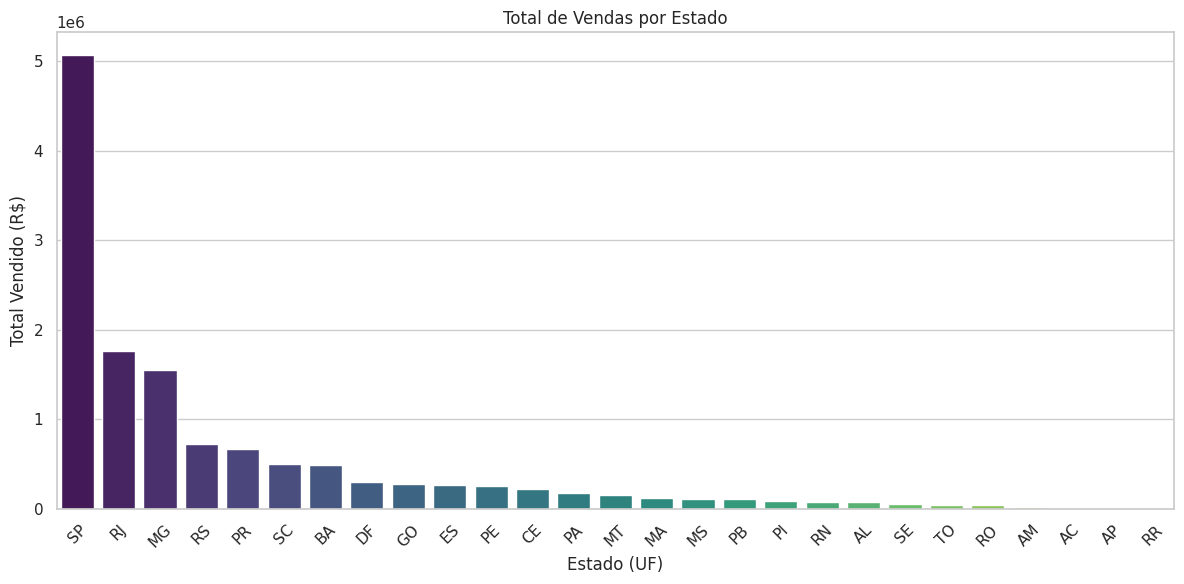

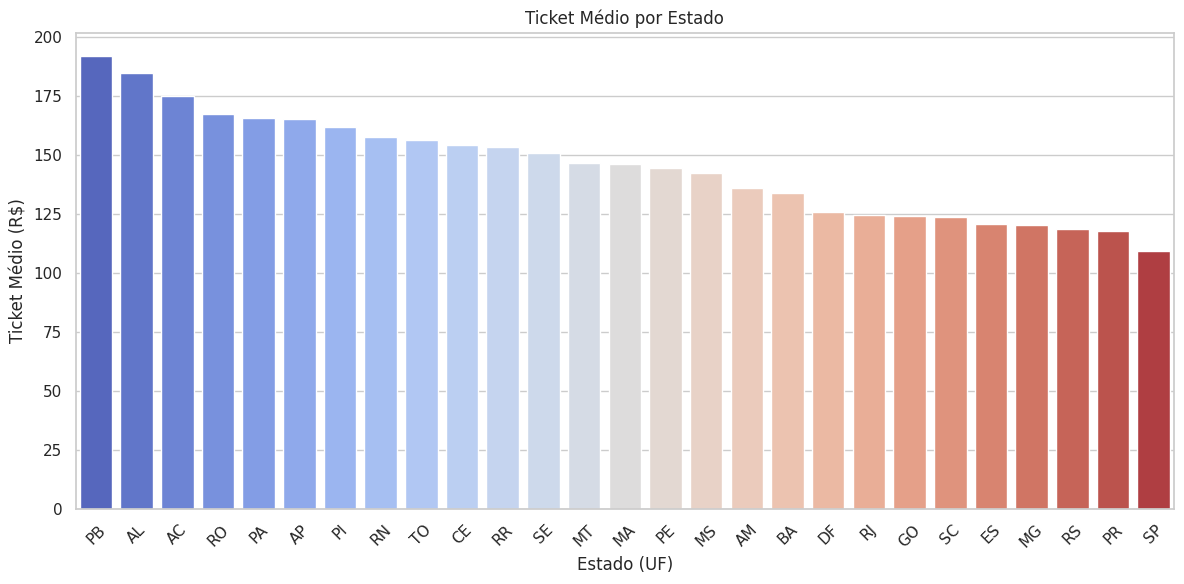

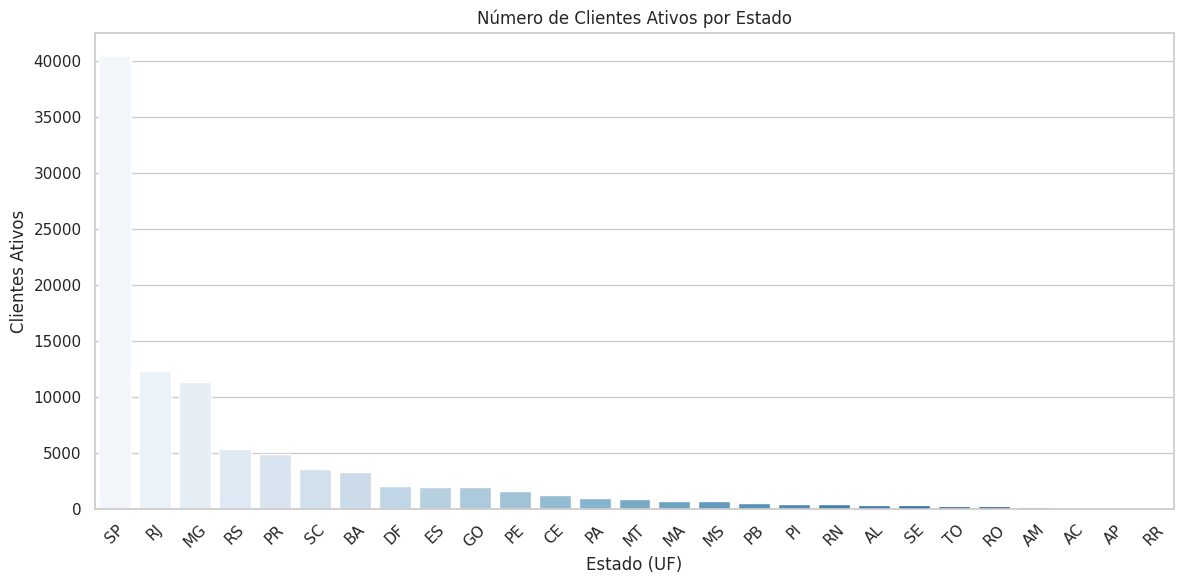

In [149]:

#  GRÁFICOS 
plt.figure(figsize=(12, 6))
sns.barplot(
    data=state_summary.sort_values('total_vendas', ascending=False),
    x='customer_state', y='total_vendas',
    hue='customer_state', palette='viridis', dodge=False, legend=False
)
plt.title('Total de Vendas por Estado')
plt.xlabel('Estado (UF)')
plt.ylabel('Total Vendido (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=state_summary.sort_values('ticket_medio', ascending=False),
    x='customer_state', y='ticket_medio',
    hue='customer_state', palette='coolwarm', dodge=False, legend=False
)
plt.title('Ticket Médio por Estado')
plt.xlabel('Estado (UF)')
plt.ylabel('Ticket Médio (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=state_summary.sort_values('clientes_ativos', ascending=False),
    x='customer_state', y='clientes_ativos',
    hue='customer_state', palette='Blues', dodge=False, legend=False
)
plt.title('Número de Clientes Ativos por Estado')
plt.xlabel('Estado (UF)')
plt.ylabel('Clientes Ativos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Segmentação por valor gasto


- Calcula o total gasto por cliente, somando os valores de todos os pedidos realizados por cada um.
- O StandardScaler padroniza a variável total_spent para que ela tenha média 0 e desvio padrão 1.
- Aplicação de clusterização para classificar os clientes em faixas de gastos
- Visualização das segmentações através do boxplot que facilita para ter uma visão geral sobre cada grupo


#### Motivos para segmentar por valor gasto

- Compreensão do perfil econômico dos clientes





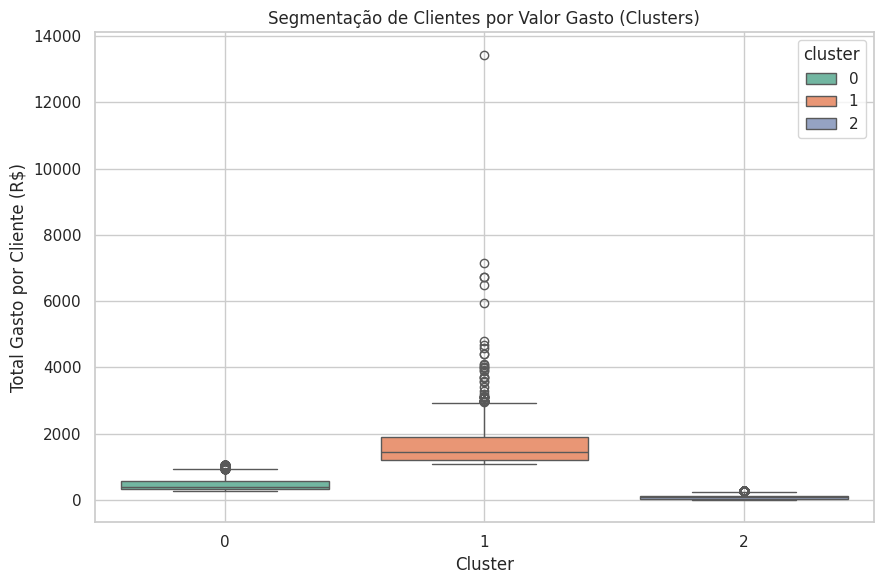

,Cluster,Qtd Clientes,Gasto Médio (R$),Mínimo (R$),Máximo (R$)
0,0,8330,468.623531,279.49,1069.36
1,1,819,1679.414811,1074.38,13440.00
2,2,87312,90.937912,0.85,279.00


In [150]:
# Total gasto por cliente
order_total = order_items_df.groupby('order_id')['price'].sum().reset_index()
order_total = pd.merge(order_total, orders_df[['order_id', 'customer_id']], on='order_id')
customer_spending = order_total.groupby('customer_id')['price'].sum().reset_index().rename(columns={'price': 'total_spent'})

# Aplicando KMeans apenas com total_spent
scaler = StandardScaler()
X = scaler.fit_transform(customer_spending[['total_spent']])

kmeans = KMeans(n_clusters=3, random_state=42)
customer_spending['cluster'] = kmeans.fit_predict(X)

# Visualização dos clusters
plt.figure(figsize=(9, 6))
sns.boxplot(data=customer_spending, x='cluster', y='total_spent', hue='cluster', palette='Set2', dodge=False)
plt.title('Segmentação de Clientes por Valor Gasto (Clusters)')
plt.xlabel('Cluster')
plt.ylabel('Total Gasto por Cliente (R$)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Estatísticas descritivas por cluster
cluster_stats = customer_spending.groupby('cluster')['total_spent'].agg(['count', 'mean', 'min', 'max']).reset_index()
cluster_stats.columns = ['Cluster', 'Qtd Clientes', 'Gasto Médio (R$)', 'Mínimo (R$)', 'Máximo (R$)']
display(cluster_stats)


### Clusters de Clientes por Valor Gasto

**0 Econômicos	R$ 400–700	Muitos clientes, baixo ticket**

**1	Clientes Regulares / VIP	R$ 1.200–2.000+	Menor número, alto valor unitário**

**2	Compradores Oportunos	R$ 100–300	Compras pontuais, dispersos**

### Estratégias de Marketing por Grupo

#### Cluster 0 – Clientes Econômicos

Comportamento: compram pouco, mas em volume razoável.

**Estratégias:** 

- Campanhas de upsell com combos e descontos progressivos.
- E-mails com ofertas de baixo custo, frete grátis acima de X reais.
- Criar um programa de fidelidade simples para incentivar uma segunda compra.

#### Cluster 1 – Clientes Regulares / VIP
Comportamento: gastam mais por pedido, mesmo comprando uma vez.

**Estratégias:**

- Benefícios exclusivos: cashback, brindes surpresa.
- Comunicação personalizada com recomendações premium.
- Convites para eventos/vendas antecipadas.

#### Cluster 2 – Compradores Oportunos

Comportamento: fizeram uma compra pequena e não voltaram.

**Estratégias:**

- Campanhas de remarketing com cupom de “segunda compra”.
- Pesquisas rápidas pós-compra para entender o que impediria uma nova.
- Abordagem com senso de urgência (“sua última oferta termina hoje”).

### Análise Regional (UF)

Estados como SP, RJ e MG dominam em volume absoluto de vendas e número de clientes.

Mas PB, AL e AC têm os maiores tickets médios, ou seja, clientes gastam mais por pedido nesses estados.

**Estratégia por região:**

SP/RJ/MG: foco em logística, ofertas frequentes e campanhas de massa.

Estados com alto ticket médio: campanhas com produtos premium, entrega expressa, e cross-sell no pós-venda.

### Conclusão
A segmentação revelou três perfis de clientes baseados no valor de compra. O cluster de clientes VIPs representa uma oportunidade de retenção estratégica. Já os compradores de menor valor requerem ações de incentivo à recompra. A análise regional também destaca a importância de estratégias localizadas: enquanto SP domina em volume, estados como PB e AL têm clientes com maior disposição para gastar. Estratégias personalizadas por cluster e região aumentam as chances de fidelização e crescimento sustentável.

## Análise de Satisfação

In [151]:
# Junta reviews com orders para obter dados de entrega e avaliação
reviews_orders = order_reviews_df.merge(orders_df, on='order_id', how='inner')

# Calcular tempos em dias (entrega real, estimada e atraso)
reviews_orders['actual_delivery_time'] = (
    pd.to_datetime(reviews_orders['order_delivered_customer_date']) - 
    pd.to_datetime(reviews_orders['order_purchase_timestamp'])
).dt.days

reviews_orders['estimated_delivery_time'] = (
    pd.to_datetime(reviews_orders['order_estimated_delivery_date']) - 
    pd.to_datetime(reviews_orders['order_purchase_timestamp'])
).dt.days

# Atraso na entrega: só considera atrasos positivos, senão zero
reviews_orders['delivery_delay'] = (
    pd.to_datetime(reviews_orders['order_delivered_customer_date']) - 
    pd.to_datetime(reviews_orders['order_estimated_delivery_date'])
).dt.days
reviews_orders['delivery_delay'] = reviews_orders['delivery_delay'].apply(lambda x: x if x > 0 else 0)

# Junta com order_items para obter preço do item e valor do frete
df = reviews_orders.merge(order_items_df, on='order_id', how='inner')

# Junta com products para obter categoria do produto
df = df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='left')

# Junta com category_df para obter nome da categoria 
df = df.merge(category_df, on='product_category_name', how='left')

# Junta com pagamentos para obter valor pago total e número de parcelas
df = df.merge(order_payments_df[['order_id', 'payment_value', 'payment_installments']], on='order_id', how='left')

# Agrupa por nota de avaliação e calcular médias para os aspectos numéricos
# Também identifica a categoria mais frequente para aquela nota
result = df.groupby('review_score').agg({
    'actual_delivery_time': 'mean',           
    'delivery_delay': 'mean',                  
    'price': 'mean',                           
    'freight_value': 'mean',                   
    'payment_value': 'mean',                    
    'payment_installments': 'mean',            
    'product_category_name_english': lambda x: x.mode().iloc[0] if not x.mode().empty else None  
}).reset_index()

# 8. Renomear colunas para facilitar interpretação
result.rename(columns={
    'actual_delivery_time': 'avg_delivery_time_days',
    'delivery_delay': 'avg_delivery_delay_days',
    'price': 'avg_item_price',
    'freight_value': 'avg_freight_cost',
    'payment_value': 'avg_payment_amount',
    'payment_installments': 'avg_num_installments',
    'product_category_name_english': 'most_common_category'
}, inplace=True)


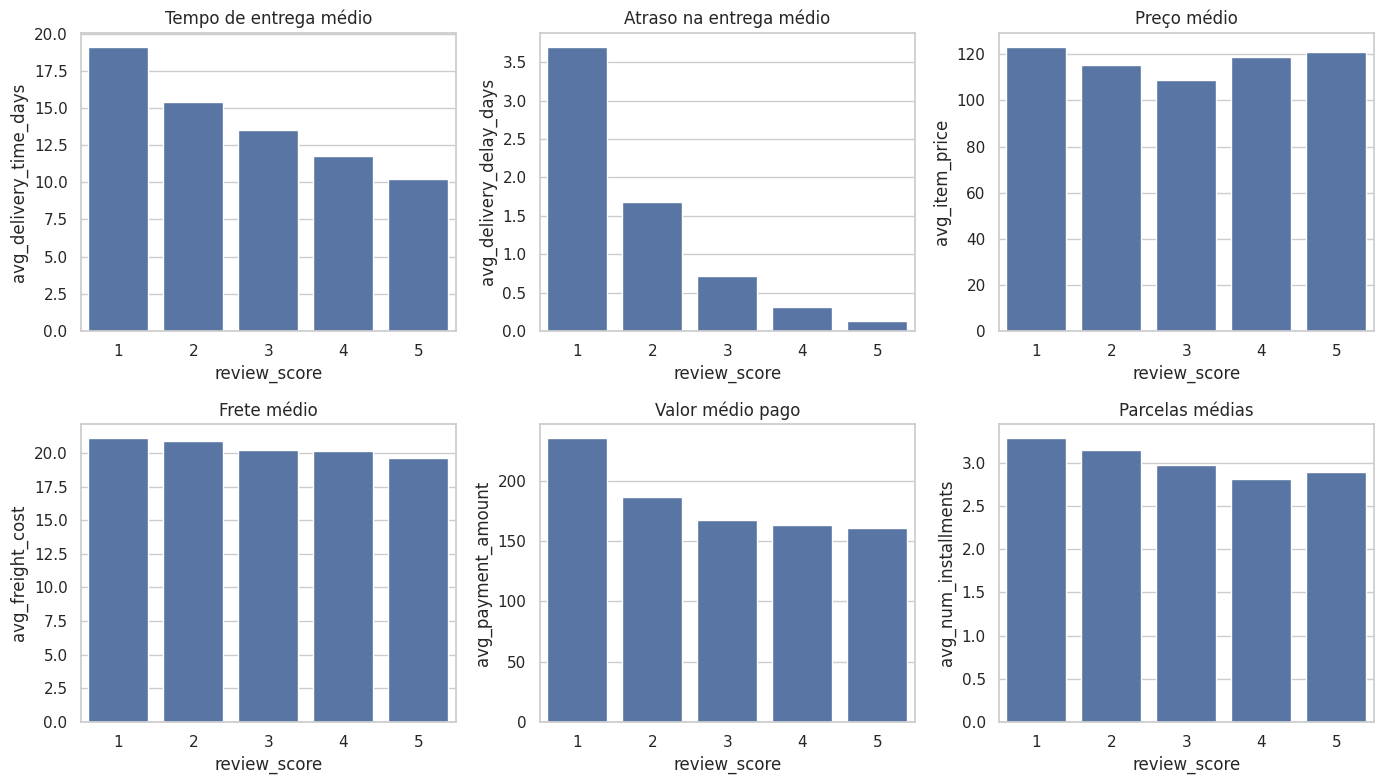

In [152]:
# Plotagem dos resultados
sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))

# Tempo de entrega médio
plt.subplot(2, 3, 1)
sns.barplot(x='review_score', y='avg_delivery_time_days', data=result)
plt.title('Tempo de entrega médio')

# Atraso médio
plt.subplot(2, 3, 2)
sns.barplot(x='review_score', y='avg_delivery_delay_days', data=result.round(2))
plt.title('Atraso na entrega médio')

# Preço médio
plt.subplot(2, 3, 3)
sns.barplot(x='review_score', y='avg_item_price', data=result)
plt.title('Preço médio')

# Frete médio
plt.subplot(2, 3, 4)
sns.barplot(x='review_score', y='avg_freight_cost', data=result)
plt.title('Frete médio')

# Valor total pago
plt.subplot(2, 3, 5)
sns.barplot(x='review_score', y='avg_payment_amount', data=result)
plt.title('Valor médio pago')

# Parcelas médias
plt.subplot(2, 3, 6)
sns.barplot(x='review_score', y='avg_num_installments', data=result)
plt.title('Parcelas médias')

plt.tight_layout()
plt.show()

# Visualização e Dashboards

### Telas
- Evolução das vendas ao longo do tempo.
    - Filtros: Estado do cliente (customer_state) e categoria do produto.
    - Agrupamento mensal das vendas.
    - Gráfico de linha com a soma total das vendas ao longo do tempo.


- Mapa de calor de vendas por estado.
    - Agrupa o valor total vendido por estado (customer_state).

- Relação entre avaliação do cliente e tempo de entrega.
    - Calcula o tempo de entrega por pedido.
    - Boxplot que relaciona notas de avaliação (review_score) com o tempo de entrega (tempo_entrega).

- Desempenho dos vendedores.
    - Métricas por vendedor



In [153]:
app = Dash(__name__, suppress_callback_exceptions=True)
app.title = "Dashboard de Vendas"
server = app.server

app.layout = html.Div([
    dcc.Location(id='url'),
    html.Div([
        dcc.Link('📈 Vendas ao longo do tempo', href='/'),
        html.Span(" | "),
        dcc.Link('🗺️ Mapa de calor de vendas', href='/mapa'),
        html.Span(" | "),
        dcc.Link('⏱️ Avaliação x Entrega', href='/avaliacao'),
        html.Span(" | "),
        dcc.Link('📊 Análise de Vendedores', href='/vendedores'),
    ], style={'padding': '20px', 'fontWeight': 'bold'}),

    html.Div(id='page-content')
])


# PÁGINA 1 - Evolução das vendas
def pagina_vendas():
    merged = (orders_df
              .merge(order_items_df, on="order_id")
              .merge(customers_df[['customer_id', 'customer_state']], on="customer_id")
              .merge(products_df[['product_id', 'product_category_name']], on="product_id")
              .merge(category_df, on="product_category_name", how='left'))

    merged['order_purchase_date'] = merged['order_purchase_timestamp'].dt.to_period("M").dt.to_timestamp()

    estados = sorted(merged['customer_state'].dropna().unique())
    categorias = sorted(merged['product_category_name_english'].dropna().unique())

    return html.Div([
        html.H2("Evolução das Vendas ao Longo do Tempo"),
        dcc.Dropdown(estados, id="estado-dropdown", placeholder="Selecione um estado", multi=True),
        dcc.Dropdown(categorias, id="categoria-dropdown", placeholder="Selecione categorias", multi=True),
        dcc.Graph(id="grafico-vendas")
    ])

# PÁGINA 2 - Mapa de calor de vendas
def pagina_mapa():
    merged = (
        orders_df[['order_id', 'customer_id']]
        .merge(customers_df, on='customer_id')
        .merge(order_items_df[['order_id', 'price']], on='order_id')
    )

    vendas_estado = merged.groupby('customer_state')['price'].sum().reset_index()

    fig = px.choropleth(
        vendas_estado,
        geojson='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson',
        locations='customer_state',
        color='price',
        featureidkey='properties.sigla',
        title='Volume Total de Vendas por Estado',
        color_continuous_scale='Viridis',
        scope='south america'
    )

    fig.update_geos(fitbounds="locations", visible=False)

    return html.Div([
        html.H2("Mapa de Calor das Vendas por Estado"),
        dcc.Graph(figure=fig)
    ])


# PÁGINA 3 - Avaliação x Tempo de entrega

def pagina_avaliacao_entrega():
    df = (orders_df
          .merge(order_reviews_df, on="order_id")
          .copy())

    df["tempo_entrega"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
    df = df[df["tempo_entrega"] >= 0]

    fig = px.box(df, x="review_score", y="tempo_entrega", points=False,
                 labels={"tempo_entrega": "Tempo de Entrega (dias)", "review_score": "Nota de Avaliação"},
                 title="Distribuição do Tempo de Entrega por Nota de Avaliação")

    return html.Div([
        html.H2("Relação entre Avaliação e Tempo de Entrega"),
        dcc.Graph(figure=fig)
    ])


# PÁGINA 4 - Desempenho dos vendedores
def pagina_vendedores():
    df = (order_items_df
          .merge(orders_df[['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date']], on='order_id')
          .merge(order_reviews_df[['order_id', 'review_score']], on='order_id', how='left'))

    df["tempo_entrega"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
    df = df[df["tempo_entrega"] >= 0]


    resumo = df.groupby('seller_id').agg(
        total_vendas=pd.NamedAgg(column='price', aggfunc='sum'),
        media_avaliacao=pd.NamedAgg(column='review_score', aggfunc='mean'),
        tempo_medio_entrega=pd.NamedAgg(column='tempo_entrega', aggfunc='mean')
    ).reset_index()

    top_vendas = px.bar(resumo.sort_values(by='total_vendas', ascending=False).head(10),
                        x='seller_id', y='total_vendas', title='Top 10 Vendedores por Volume de Vendas')

    top_avaliacao = px.bar(resumo.sort_values(by='media_avaliacao', ascending=False).head(10),
                           x='seller_id', y='media_avaliacao', title='Top 10 Vendedores por Avaliação Média')

    top_entrega = px.bar(resumo.sort_values(by='tempo_medio_entrega').head(10),
                         x='seller_id', y='tempo_medio_entrega', title='Top 10 Vendedores por Entrega Mais Rápida')

    return html.Div([
        html.H2("Análise de Desempenho dos Vendedores"),
        dcc.Graph(figure=top_vendas),
        dcc.Graph(figure=top_avaliacao),
        dcc.Graph(figure=top_entrega),
    ])

# CALLBACKS
@app.callback(
    Output('grafico-vendas', 'figure'),
    Input('estado-dropdown', 'value'),
    Input('categoria-dropdown', 'value')
)
def atualizar_grafico_vendas(estados, categorias):
    df = (orders_df
          .merge(order_items_df, on="order_id")
          .merge(customers_df[['customer_id', 'customer_state']], on="customer_id")
          .merge(products_df[['product_id', 'product_category_name']], on="product_id")
          .merge(category_df, on="product_category_name", how='left'))

    df['order_purchase_date'] = df['order_purchase_timestamp'].dt.to_period("M").dt.to_timestamp()

    if estados:
        df = df[df['customer_state'].isin(estados)]
    if categorias:
        df = df[df['product_category_name_english'].isin(categorias)]

    vendas = df.groupby('order_purchase_date')['price'].sum().reset_index()

    fig = px.line(vendas, x='order_purchase_date', y='price',
                  labels={"order_purchase_date": "Data da Compra", "price": "Total Vendido (R$)"},
                  title="Evolução Mensal das Vendas")

    return fig


# ROTEAMENTO DE PÁGINAS
@app.callback(Output('page-content', 'children'),
              Input('url', 'pathname'))
def display_page(pathname):
    if pathname == '/mapa':
        return pagina_mapa()
    elif pathname == '/avaliacao':
        return pagina_avaliacao_entrega()
    elif pathname == '/vendedores':
        return pagina_vendedores()
    else:
        return pagina_vendas()

# Executa o servidor
if __name__ == '__main__':
    app.run(debug=True)
